<a href="https://colab.research.google.com/github/dougfletcher10/W207/blob/master/Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## K-Nearest Neighbors

KNN is one of the more intuitive classifiers. It requires a set of labeled training data. K can take on any positive integer value (1,2,3...) . When given a test point, it looks at the K closest neighbors, then guesses the most common label from amongst those points

What design restrictions does this approach put in place?

### Building intuition

In [0]:
# Import a bunch of libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

In [0]:
np.random.seed(0)

def generate_labeled_points(num_points, scale_factor = 5):
  points = []
  for i in range(num_points):
    x = random.random() * scale_factor
    y = random.random() * scale_factor
    
    if y >= x:
      label = 0
    else:
      label = 1
    points.append([x, y, label])
  return points

In [0]:
labeled_points = generate_labeled_points(150)
df = pd.DataFrame(labeled_points, columns=['x','y','label']) 
df.head()

,x,y,label
0,4.401165,3.046157,1
1,4.374553,0.892978,1
2,3.707427,0.465175,1
3,0.484688,3.259621,0
4,0.248501,4.878692,0


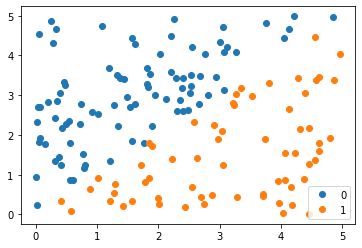

In [0]:

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
ax.legend()

plt.show()

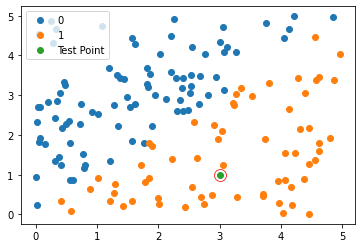

In [0]:
test_x, test_y = 3, 1

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)


ax.plot(test_x, test_y, marker='o', linestyle='', ms=6, label="Test Point")
ax.plot(test_x, test_y, "ro", ms=12, mew=.75, markerfacecolor="None", markeredgecolor='red', linestyle='')
ax.legend()

plt.show()



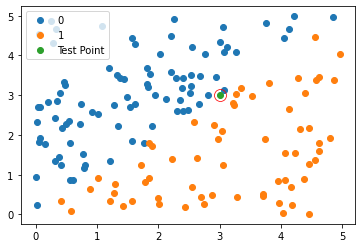

In [0]:
test_x, test_y = 3, 3

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)


ax.plot(test_x, test_y, marker='o', linestyle='', ms=6, label="Test Point")
ax.plot(test_x, test_y, "ro", ms=12, mew=.75, markerfacecolor="None", markeredgecolor='red', linestyle='')
ax.legend()

plt.show()



## More complicated  examples -- Irises

Load the Iris data to use for experiments. The data include 50 observations of each of 3 types of irises (150 total). Each observation includes 4 measurements: sepal and petal width and height. The goal is to predict the iris type from these measurements.

http://en.wikipedia.org/wiki/Iris_flower_data_set

You will become very familiar with the Iris data set

In [0]:
from sklearn.datasets import load_iris

# Load the data, which is included in sklearn.
iris = load_iris()
print ('Iris target names:', iris.target_names)
print ('Iris feature names:', iris.feature_names)
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


## Visualize the data

Do you think KNN will work well for this data set?

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


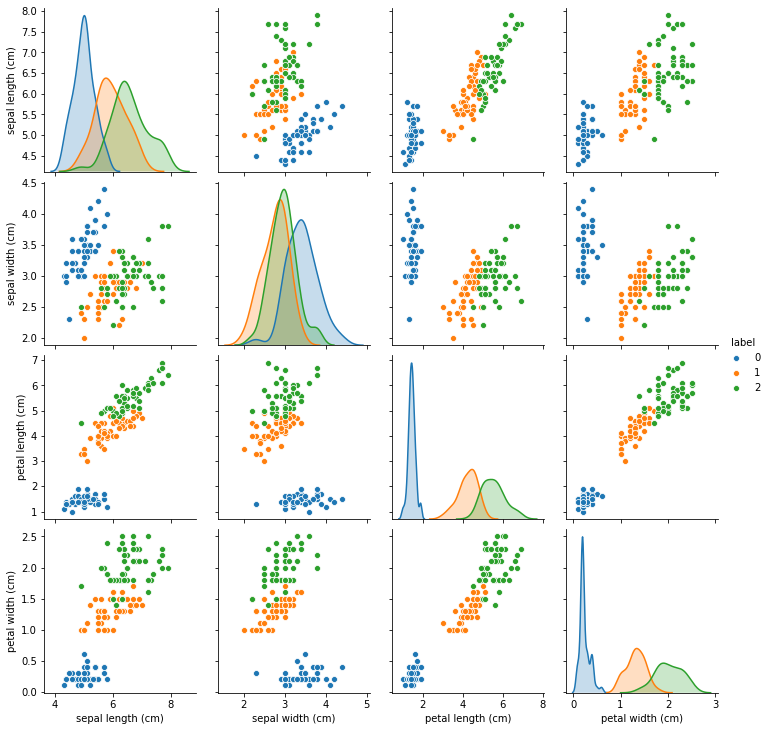

In [0]:
# Seaborn visualization library
import seaborn as sns

sepal_df = pd.DataFrame(iris['data'], columns  =  iris.feature_names)
sepal_df["label"] = iris.target
sepal_df.head()

# Create the default pairplot
cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
sns.pairplot(sepal_df, vars = cols,  hue = "label")

# Question - Do you think KNN will perform well on this dataset? Why or why not? Will it make any systematic errors?

We care about how far away each point is from another in this 4 dimensional space, so let's look at the distribution of distances

In [0]:
# pythagorean theorm - a**2 + b**2 = c**2
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

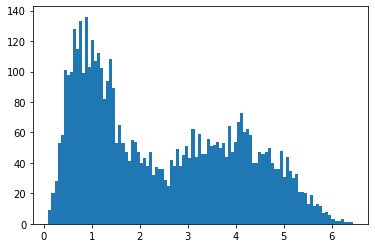

In [0]:
dists = []
for i in range(len(train_data) - 1):
    for j in range(i + 1, len(train_data)):
        dist = EuclideanDistance(train_data[i], train_data[j])
        dists.append(dist)
        
fig = plt.hist(dists, 100)

## Test KNN
Ok now let's create a class that implements a Nearest Neighbors classifier. We'll model it after the sklearn classifier implementations, with fit() and predict() methods.

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [0]:
class NearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, metric=EuclideanDistance):
        self.metric = metric
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return results
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        best_dist, best_label = 1.0e10, None
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            if dist < best_dist:
                best_label = self.train_labels[i]
                best_dist = dist
        return best_label

Run an experiment with the classifier.

In [0]:
clf = NearestNeighbors()
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)
wrong_labels = []

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    else: wrong_labels.append((pred,label))
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))
wrong_labels

total:  50  correct:  48  accuracy: 0.96


[(2, 1), (2, 1)]

## More complicated examples - decision boundaries

Text(0.5, 1.0, 'Data Scatterplot; Red: Class 0; Blue: Class 1')

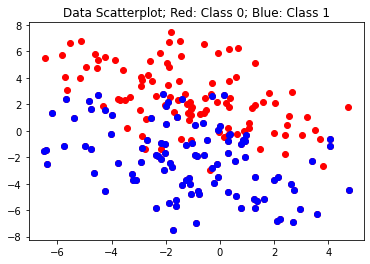

In [0]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

np.random.seed(0) # so things are 'random'

# a function to generate some simulated data
def make_data(n_per_class):
    # initializing data arrays
    group = np.empty((0, 2))
    group_labels = np.empty((0, 0))
    
    # a function to define the decision boundary between x and y
    boundary_function = lambda x: (x**3.0 + 3.0 * x**2.0 - 6.0 * x- 8.0) / 4.0
    
    for i in range(2):
        # x values
        x_value = np.random.uniform(-4, 2, size=n_per_class[i])
        
        
        # here's how the decision boundary works: we add noise so the y value point lies above or
        # below the decision boundary
        if i ==0:
            y_noise = np.random.uniform(-0.5, 5.0, size=n_per_class[i])
        else:
            y_noise = np.random.uniform(-5.0, 0.5, size=n_per_class[i])
            
        # make the x and y values
        y_value = boundary_function(x_value) + y_noise
        
        x_noise = np.random.uniform(-3, 3, size=n_per_class[i])
        x_value = x_value + x_noise
        
        # assemble the data
        tmp_group_data = np.append(x_value, y_value)
        tmp_group_data = tmp_group_data.reshape(n_per_class[i], 2, order='F')
    
        # assemble the labels
        tmp_group_labels = np.repeat([i], n_per_class[i])
    
        group = np.vstack((group, tmp_group_data))
        group_labels = np.append(group_labels, tmp_group_labels)
    
    # return a dict of data and labels
    return({'group': group, 'group_labels': group_labels})


# make data; get out the data and labels
training_data = make_data([100, 100])
train_X = training_data['group']
train_labels = training_data['group_labels']

# plot it!
plt.plot(train_X[:, 0], train_X[:, 1], 'ro')
plt.plot(train_X[np.where(train_labels==1), 0][0], 
         train_X[np.where(train_labels==1), 1][0], 'bo')
plt.title("Data Scatterplot; Red: Class 0; Blue: Class 1")



In [0]:

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_decision_boundary(X, labels, h=.02, newplot=True, markersize=None):

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    if newplot:
      plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    if markersize:
      plt.plot(X[:, 0], X[:, 1], 'ro', markersize=markersize)
    else:
      plt.plot(X[:, 0], X[:, 1], 'ro')
    plt.plot(X[np.where(labels==1), 0][0], 
         X[np.where(labels==1), 1][0], 'bo')

    return plt

In [0]:
k = 25


model = KNeighborsClassifier(n_neighbors=k)
model.fit(train_X, train_labels)
train_predicted_labels = model.predict(train_X)

print("number misclassified ... ", sum(train_labels != train_predicted_labels))

    


number misclassified ...  32


Text(0.5, 1.0, 'k=25')

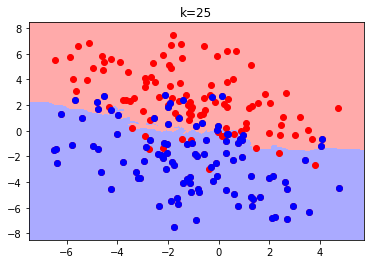

In [0]:
p = plot_decision_boundary(train_X, train_labels)
p.title("k=%d" % k)

number misclassified ...  0


Text(0.5, 1.0, 'k=1')

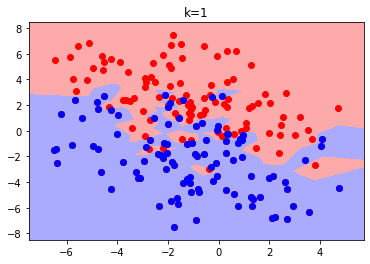

In [0]:
# all together now

k = 1

model = KNeighborsClassifier(n_neighbors=k)
model.fit(train_X, train_labels)
train_predicted_labels = model.predict(train_X)

print("number misclassified ... ", sum(train_labels != train_predicted_labels))

p = plot_decision_boundary(train_X, train_labels)
p.title("k=%d" % k)


## Testing with Novel data (outside the training set)

number of incorrect predictions: 28


Text(0.5, 1.0, 'k=5')

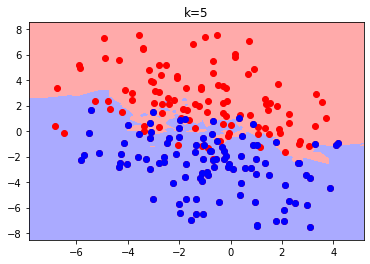

In [0]:
# fit KNN to the train data, and predict on the test date and see what it gets wrong?

np.random.seed(5) # so things are 'random'

test_data = make_data([100, 100])
test_X = test_data['group']
test_true_labels = test_data['group_labels']

# try out some different k here
k = 5
model = KNeighborsClassifier(n_neighbors=k)
model.fit(train_X, train_labels)
test_predicted_labels = model.predict(test_X)

wrong_prediction = (test_predicted_labels != test_true_labels)
print ('number of incorrect predictions:', np.sum(wrong_prediction) )


p = plot_decision_boundary(test_X, test_true_labels)
p.title("k=%d" % k)
    



k=1: number misclassified ...  33
k=3: number misclassified ...  29
k=5: number misclassified ...  28
k=7: number misclassified ...  29
k=9: number misclassified ...  31
k=11: number misclassified ...  31
k=13: number misclassified ...  27
k=15: number misclassified ...  28
k=17: number misclassified ...  28
k=19: number misclassified ...  29


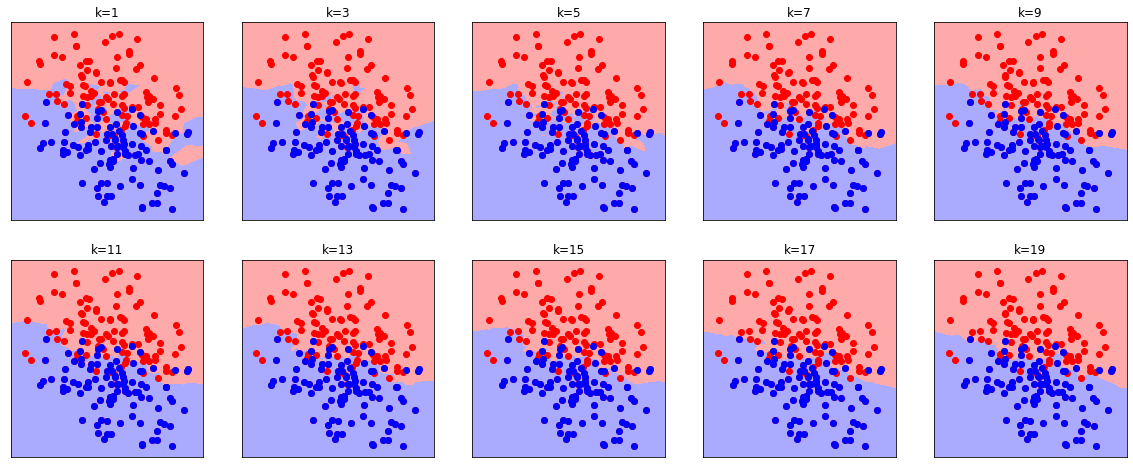

In [0]:
import math
# loop over a bunch of k values

k_vals = list(range(1,20,2))

plt.figure(figsize=(20, 8))

scores = []

for i,k in enumerate(k_vals):
    # The subplots are all on the same row.
    ax = plt.subplot(2, 5, i+1)
    
    # Turn off tick marks to keep things clean.
    plt.setp(ax, xticks=(), yticks=())
    
    
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_X, train_labels)
    test_predicted_labels = model.predict(test_X)

    num_wrong = sum(test_true_labels != test_predicted_labels)
    print("k=%d: number misclassified ... "  % k ,num_wrong)

    p = plot_decision_boundary(test_X, test_true_labels, newplot=False, markersize=6)
    p.title("k=%d" % k)
    scores.append((k, num_wrong))
p.show()

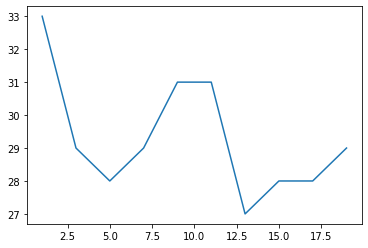

In [0]:
plt.plot([x[0] for x in scores], [x[1] for x in scores])

## Experiments with distance metric

In [0]:
dist = DistanceMetric.get_metric('manhattan')

X = [[0, 0],
     [3, 4]]

dist.pairwise(X)

array([[0., 7.],
       [7., 0.]])

In [0]:
dist = DistanceMetric.get_metric('euclidean')

X = [[0, 0],
     [3, 4]]

dist.pairwise(X)

array([[0., 5.],
       [5., 0.]])

metric=euclidean, k=1: number misclassified ... 33
metric=euclidean, k=6: number misclassified ... 31
metric=euclidean, k=11: number misclassified ... 31
metric=euclidean, k=16: number misclassified ... 27
metric=manhattan, k=1: number misclassified ... 30
metric=manhattan, k=6: number misclassified ... 32
metric=manhattan, k=11: number misclassified ... 29
metric=manhattan, k=16: number misclassified ... 27


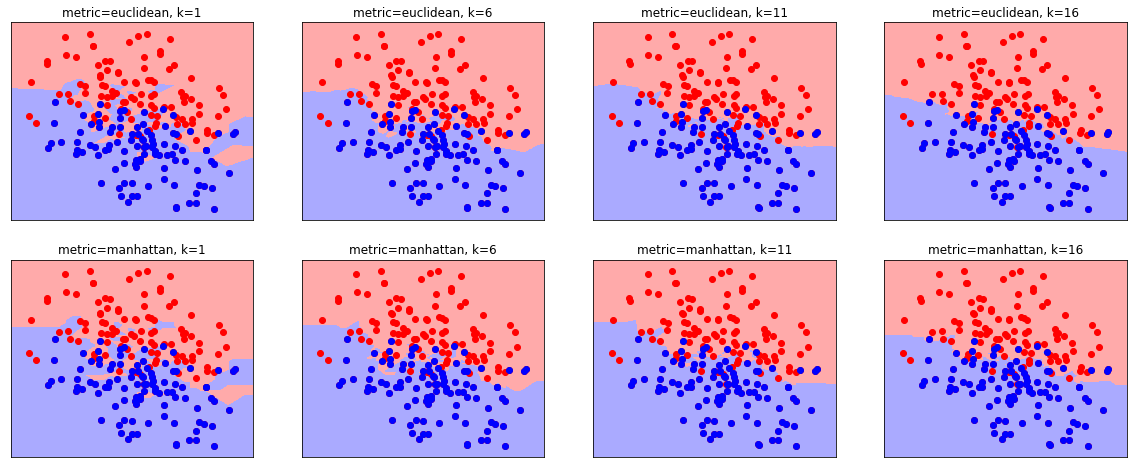

In [0]:
k_vals = list(range(1,20,5))

plt.figure(figsize=(20, 8))

for j, metric in enumerate(["euclidean", "manhattan"]):
  for i,k in enumerate(k_vals):
    # The subplots are all on the same row.
    ax = plt.subplot(2, len(k_vals), (j * len(k_vals)) + i + 1)

    # Turn off tick marks to keep things clean.
    plt.setp(ax, xticks=(), yticks=())

    model = KNeighborsClassifier(n_neighbors=k, metric=metric)
    model.fit(train_X, train_labels)
    test_predicted_labels = model.predict(test_X)

    num_wrong = sum(test_true_labels != test_predicted_labels)
    print("metric=%s, k=%d: number misclassified ... %d"  % (metric, k ,num_wrong))

    p = plot_decision_boundary(test_X, test_true_labels, newplot=False, markersize=6)
    p.title("metric=%s, k=%d" % (metric, k))

p.show()

## Scaling the data is important

In [0]:
# scaling the data is important!

# the loan data, two covariates
loan = np.array([40000, 60000, 80000, 20000, 120000, 62000, 100000, 220000, 150000])
age = np.array([25, 35, 45, 20, 35, 40, 60, 48, 33])

raw_loan_data = np.hstack((loan.reshape(9, 1), age.reshape(9, 1)))
loan_labels = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1])

print (np.hstack((raw_loan_data, loan_labels.reshape(9, 1))))
# fit a knn in the original space
model_raw = KNeighborsClassifier(n_neighbors=1)
model_raw.fit(raw_loan_data, loan_labels)

# predicting in the original space
print ("Original space pred:   ", model_raw.predict([[21000, 45]]))

# functions to normalize the two features
norm_loan = lambda x: (x - np.mean(loan)) / np.std(loan)
norm_age = lambda x: (x - np.mean(age)) / np.std(age)

# make normalized versions of the features; fit a new model
loan_normalized = norm_loan(loan)
age_normalized = norm_age(age)
normalized_loan_data = np.hstack((loan_normalized.reshape(9, 1), 
                                  age_normalized.reshape(9, 1)))

model_normalized = KNeighborsClassifier(n_neighbors=1)
model_normalized.fit(normalized_loan_data, loan_labels)

# note that we must predict in norm space
print ("Normalized space pred: ", model_normalized.predict([[norm_loan(21000), norm_age(45)]]))

[[ 40000     25      0]
 [ 60000     35      0]
 [ 80000     45      0]
 [ 20000     20      0]
 [120000     35      0]
 [ 62000     40      1]
 [100000     60      1]
 [220000     48      1]
 [150000     33      1]]
Original space pred:    [0]
Normalized space pred:  [1]


(-3.0, 3.0, -3.0, 3.0)

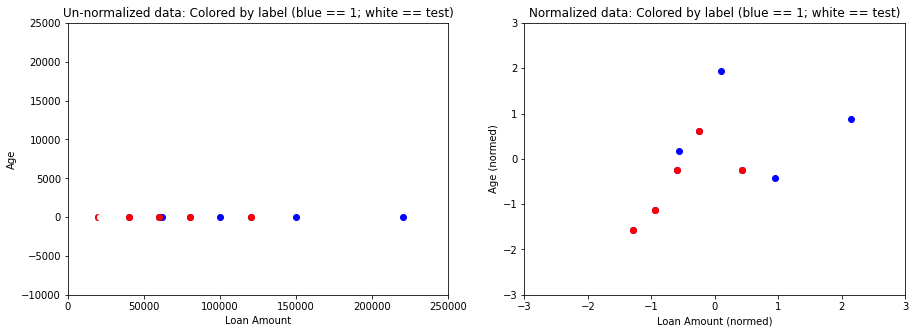

In [0]:
# what is going on? let's plot it!
plt.figure(figsize=(15,5))

# raw space
plt.subplot(1, 2, 1)
plt.plot(loan, age, 'bo')
plt.plot(loan[np.where(loan_labels==0)], 
         age[np.where(loan_labels==0)], 'ro')
plt.plot([21000], [45], 'wo')
plt.title("Un-normalized data: Colored by label (blue == 1; white == test)")
plt.xlabel('Loan Amount')
plt.ylabel('Age')
plt.axis([-10, 250000, -10000, 25000]) 

# normalized space
plt.subplot(1, 2, 2)
plt.plot(loan_normalized, age_normalized, 'bo')
plt.plot(loan_normalized[np.where(loan_labels==0)], 
         age_normalized[np.where(loan_labels==0)], 'ro')
plt.plot([norm_loan(21000)], [norm_age(45)], 'wo')
plt.title("Normalized data: Colored by label (blue == 1; white == test)")
plt.xlabel('Loan Amount (normed)')
plt.ylabel('Age (normed)')
plt.axis([-3, 3, -3, 3])


## Example - movie recommenders

In [0]:
# from https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

sample_link = "https://gist.githubusercontent.com/onelharrison/443fe58ec1e15b18b19f305441cf7173/raw/a97be8160b63c6607b4f4498508a3851dcd110c2/movies_recommendation_data.csv"
movies_df = pd.read_csv(sample_link)

In [0]:
movies_df.head()

,Movie ID,Movie Name,IMDB Rating,Biography,Drama,Thriller,Comedy,Crime,Mystery,History,Label
0,58,The Imitation Game,8.0,1,1,1,0,0,0,0,0
1,8,Ex Machina,7.7,0,1,0,0,0,1,0,0
2,46,A Beautiful Mind,8.2,1,1,0,0,0,0,0,0
3,62,Good Will Hunting,8.3,0,1,0,0,0,0,0,0
4,97,Forrest Gump,8.8,0,1,0,0,0,0,0,0


In [0]:
movies_list = movies_df.values.tolist() # get a list of movies and their features
movies_list[:5]


[[58, 'The Imitation Game', 8.0, 1, 1, 1, 0, 0, 0, 0, 0],
 [8, 'Ex Machina', 7.7, 0, 1, 0, 0, 0, 1, 0, 0],
 [46, 'A Beautiful Mind', 8.2, 1, 1, 0, 0, 0, 0, 0, 0],
 [62, 'Good Will Hunting', 8.3, 0, 1, 0, 0, 0, 0, 0, 0],
 [97, 'Forrest Gump', 8.8, 0, 1, 0, 0, 0, 0, 0, 0]]

In [0]:
movies_dict = {x[1]:x[2:] for x in movies_list} # build a basic 'featurizer'
movies_dict

{'12 Years a Slave': [8.1, 1, 1, 0, 0, 0, 0, 1, 0],
 '21': [6.8, 0, 1, 0, 0, 1, 0, 1, 0],
 '21 Jump Street': [7.2, 0, 0, 0, 1, 1, 0, 0, 0],
 'A Beautiful Mind': [8.2, 1, 1, 0, 0, 0, 0, 0, 0],
 'A Brilliant Young Mind': [7.2, 0, 1, 0, 0, 0, 0, 0, 0],
 'A Time To Kill': [7.4, 0, 1, 1, 0, 1, 0, 0, 0],
 'Avatar': [7.9, 0, 0, 0, 0, 0, 0, 0, 0],
 'Black Panther': [7.4, 0, 0, 0, 0, 0, 0, 0, 0],
 'Ex Machina': [7.7, 0, 1, 0, 0, 0, 1, 0, 0],
 'Finding Forrester': [7.3, 0, 1, 0, 0, 0, 0, 0, 0],
 'Forrest Gump': [8.8, 0, 1, 0, 0, 0, 0, 0, 0],
 'Gifted': [7.6, 0, 1, 0, 0, 0, 0, 0, 0],
 'Good Will Hunting': [8.3, 0, 1, 0, 0, 0, 0, 0, 0],
 'Hacksaw Ridge': [8.2, 1, 1, 0, 0, 0, 0, 1, 0],
 'Inception': [8.8, 0, 0, 0, 0, 0, 0, 0, 0],
 'Interstellar': [8.6, 0, 1, 0, 0, 0, 0, 0, 0],
 'Queen of Katwe': [7.4, 1, 1, 0, 0, 0, 0, 0, 0],
 'Spirit: Stallion of the Cimarron': [7.1, 0, 0, 0, 0, 0, 0, 0, 0],
 'Spirited Away': [8.6, 0, 0, 0, 0, 0, 0, 0, 0],
 'Stand and Deliver': [7.3, 0, 1, 0, 0, 0, 0, 0, 0],
 'The

## Sample KNN implementation

In [0]:

from collections import Counter
import math

def knn(data, query, k, distance_fn, choice_fn):
    neighbor_distances_and_indices = []
    
    # 1. For each example in the data
    for index, example in enumerate(data):
        # 1.1 Calculate the distance between the query example and the current
        # example from the data.
        distance = distance_fn(example[:-1], query)
        
        # 1.2 Add the distance and the index of the example to an ordered collection
        neighbor_distances_and_indices.append((distance, index))
    
    # 2. Sort the ordered collection of distances and indices from
    # smallest to largest (in ascending order) by the distances
    sorted_neighbor_distances_and_indices = sorted(neighbor_distances_and_indices)
    
    # 3. Pick the first K entries from the sorted collection
    k_nearest_distances_and_indices = sorted_neighbor_distances_and_indices[:k]
    
    # 4. Get the labels of the selected K entries
    k_nearest_labels = [data[i][1] for distance, i in k_nearest_distances_and_indices]

    # 5. If regression (choice_fn = mean), return the average of the K labels
    # 6. If classification (choice_fn = mode), return the mode of the K labels
    return k_nearest_distances_and_indices , choice_fn(k_nearest_labels)

def mean(labels):
    return sum(labels) / len(labels)

def mode(labels):
    return Counter(labels).most_common(1)[0][0]

def euclidean_distance(point1, point2):
    sum_squared_distance = 0
    for i in range(len(point1)):
        sum_squared_distance += math.pow(point1[i] - point2[i], 2)
    return math.sqrt(sum_squared_distance)


# Question - from a programming perspective, what portion of this is ineffective?

## Sample movie recommender

In [0]:
def recommend_movies(movie_query, k_recommendations, movie_list):

    # Prepare the data for use in the knn algorithm by picking
    # the relevant columns and converting the numeric columns
    # to numbers since they were read in as strings
    movies_recommendation_data = []
    for row in movie_list:
        data_row = list(map(float, row[2:]))
        movies_recommendation_data.append(data_row)

    # Use the KNN algorithm to get the 5 movies that are most
    # similar to The Post.
    recommendation_indices, _ = knn(
        movies_recommendation_data, movie_query, k=k_recommendations,
        distance_fn=euclidean_distance, choice_fn=lambda x: None
    )

    movie_recommendations = []
    for _, index in recommendation_indices:
        movie_recommendations.append(movie_list[index])

    return movie_recommendations

# Question - mathematically, what are we asking the model?
Go one level deeper than "what movie should I watch"

## Sample Query

In [0]:
movie_name = 'The DaVinci Code'
movie_features = movies_dict[movie_name]
recommended_movies = recommend_movies(movie_query=movie_features, k_recommendations=5, movie_list=movies_list)
recommended_movies

[[57, 'The DaVinci Code', 6.6, 0, 0, 1, 0, 0, 1, 0, 0],
 [12, 'Spirit: Stallion of the Cimarron', 7.1, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 'Travelling Salesman', 5.9, 0, 1, 0, 0, 0, 1, 0, 0],
 [27, 'The Fountain', 7.3, 0, 0, 0, 0, 0, 0, 0, 0],
 [6, 'Black Panther', 7.4, 0, 0, 0, 0, 0, 0, 0, 0]]

## Out of training set example

In [0]:
the_post = [7.2, 1, 1, 0, 0, 0, 0, 1, 0] # feature vector for The Post, a new movie
recommended_movies = recommend_movies(movie_query=the_post, k_recommendations=5, movie_list=movies_list)
recommended_movies

[[86, '12 Years a Slave', 8.1, 1, 1, 0, 0, 0, 0, 1, 0],
 [1, 'Hacksaw Ridge', 8.2, 1, 1, 0, 0, 0, 0, 1, 0],
 [46, 'Queen of Katwe', 7.4, 1, 1, 0, 0, 0, 0, 0, 0],
 [44, 'The Wind Rises', 7.8, 1, 1, 0, 0, 0, 0, 0, 0],
 [46, 'A Beautiful Mind', 8.2, 1, 1, 0, 0, 0, 0, 0, 0]]

# Question - Given the below examples, what movie would be picked?

In [0]:
[86, 'Query',    10.0, 0, 0, 0, 0, 0, 1, 1, 1], 

[46, 'Choice A', 2.0 , 0, 0, 0, 0, 0, 1, 1, 1],
[1,  'Choice B', 9.9 , 1, 1, 1, 0, 0, 0, 0, 0],     


([1, 'Choice B', 9.9, 1, 1, 1, 0, 0, 0, 0, 0],)

# Question - By choosing Euclidean distance as our metric, what feature are we implicitly giving the most weight to?

If this were a problem, how could we address it?